In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import gym 
import random 
import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib.pyplot import imshow, show
from IPython.display import clear_output

In [ ]:
env = gym.make('CartPole-v1', new_step_api = True)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

episodes = 100
lr = 0.0001
memory_size = 10000
batch = 64
gamma = 0.95
explore_max = 1.0
explore_decay = 0.99
explore_min = 0.01

FC1_dim = 1024
FC2_dim = 512

device = torch.device("cpu")

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []
rewards = []

NameError: name 'gym' is not defined

In [3]:
#Deep Q-Learning

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space
        
        self.fc1 = nn.Linear(*self.input_shape, FC1_dim)
        self.fc2 = nn.Linear(FC1_dim, FC2_dim)
        self.fc3 = nn.Linear(FC2_dim, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0
        self.states = np.zeros((memory_size, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(memory_size, dtype=np.int64)
        self.rewards = np.zeros(memory_size, dtype=np.float32)
        self.states_ = np.zeros((memory_size, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(memory_size, dtype=np.bool_)
    
    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % memory_size
        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done
        self.mem_count += 1
    
    def sample(self):
        mem_max = min(self.mem_count, memory_size)
        batch_indices = np.random.choice(mem_max, batch, replace=True)
        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]
        return states, actions, rewards, states_, dones
    
class DQN_Solver:
    def __init__(self):
        
        self.memory = ReplayBuffer()
        self.exploration_rate = explore_max
        self.network = Network()

    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return env.action_space.sample() 
        state = torch.tensor(observation).float().detach()
        state = state.unsqueeze(0)
        q_values = self.network(state)
        return torch.argmax(q_values).item()
    
    def learn(self):
        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        states_ = torch.tensor(states_, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)
        batch_indices = np.arange(batch, dtype=np.int64)

        q_values = self.network(states)
        next_q_values = self.network(states_)
        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]
        q_target = rewards + gamma * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= explore_decay
        self.exploration_rate = max(explore_min, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate
    
agent = DQN_Solver()

In [ ]:
for i in range(1, episodes):
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)[:4]
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score 
            if (i + 1) % 10 == 0:
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break
            
    episode_number.append(i)
    rewards.append(score)
    average_reward_number.append(average_reward/i)

plt.plot(episode_number, rewards)
plt.plot(episode_number, average_reward_number, color = 'g')
plt.show()

NameError: name 'episodes' is not defined

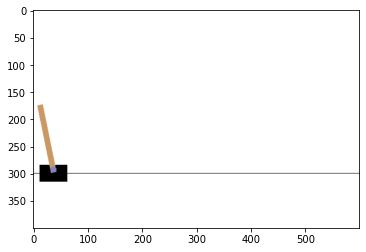

Score: 273.0


<bound method Wrapper.close of <TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>>>

In [5]:
random.seed(29)  
score = 0
state = env.reset()
done = False
  
while not done:
    clear_output(wait=True)
    plt.imshow(env.render('rgb_array'))
    show()
    action = agent.choose_action(state)
    state_, reward, done, info = env.step(action)[:4]
    state_ = np.reshape(state_, [1, observation_space])
    state = state_
    score += reward
    
print('Score:', score)
env.close

Episode 9 Average Reward 16.88888888888889 Best Reward 25.0 Last Reward 20.0 Epsilon 0.2170448966728076
Episode 19 Average Reward 27.842105263157894 Best Reward 59.0 Last Reward 47.0 Epsilon 0.01
Episode 29 Average Reward 51.41379310344828 Best Reward 151.0 Last Reward 72.0 Epsilon 0.01
Episode 39 Average Reward 84.64102564102564 Best Reward 268.0 Last Reward 166.0 Epsilon 0.01
Episode 49 Average Reward 97.95918367346938 Best Reward 268.0 Last Reward 21.0 Epsilon 0.01
Episode 59 Average Reward 105.91525423728814 Best Reward 343.0 Last Reward 343.0 Epsilon 0.01
Episode 69 Average Reward 118.72463768115942 Best Reward 446.0 Last Reward 167.0 Epsilon 0.01
Episode 79 Average Reward 144.1012658227848 Best Reward 508.0 Last Reward 263.0 Epsilon 0.01
Episode 89 Average Reward 158.26966292134833 Best Reward 508.0 Last Reward 244.0 Epsilon 0.01
Episode 99 Average Reward 172.33333333333334 Best Reward 508.0 Last Reward 448.0 Epsilon 0.01


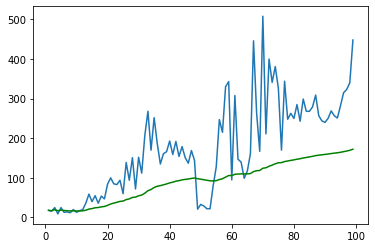

In [4]:
for i in range(1, episodes):
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)[:4]
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score 
            if (i + 1) % 10 == 0:
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break
            
    episode_number.append(i)
    rewards.append(score)
    average_reward_number.append(average_reward/i)

plt.plot(episode_number, rewards)
plt.plot(episode_number, average_reward_number, color = 'g')
plt.show()

In [6]:
env = gym.make('CartPole-v1', new_step_api = True)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

episodes = 100
lr = 0.0001
memory_size = 10000
batch = 64
gamma = 0.95
explore_max = 1.0
explore_decay = 0.99
explore_min = 0.01

FC1_dim = 1024
FC2_dim = 512

device = torch.device("cpu")

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []
rewards = []

In [7]:
#Deep Q-Learning with Main and Target Network

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space
        
        self.fc1 = nn.Linear(*self.input_shape, FC1_dim)
        self.fc2 = nn.Linear(FC1_dim, FC2_dim)
        self.fc3 = nn.Linear(FC2_dim, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0
        self.states = np.zeros((memory_size, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(memory_size, dtype=np.int64)
        self.rewards = np.zeros(memory_size, dtype=np.float32)
        self.states_ = np.zeros((memory_size, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(memory_size, dtype=np.bool_)
    
    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % memory_size
        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done
        self.mem_count += 1
    
    def sample(self):
        mem_max = min(self.mem_count, memory_size)
        batch_indices = np.random.choice(mem_max, batch, replace=True)
        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]
        return states, actions, rewards, states_, dones
    
class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = explore_max
        self.main = Network()
        self.target = Network()
        self.learn_count = 0

    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return env.action_space.sample() 
        state = torch.tensor(observation).float().detach()
        state = state.unsqueeze(0)
        q_values = self.target(state)
        return torch.argmax(q_values).item()
    
    def learn(self):
        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        states_ = torch.tensor(states_, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)
        batch_indices = np.arange(batch, dtype=np.int64)

        q_values = self.main(states)
        next_q_values = self.main(states_)
        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]
        q_target = rewards + gamma * predicted_value_of_future * dones

        loss = self.main.loss(q_target, predicted_value_of_now)
        self.main.optimizer.zero_grad()
        loss.backward()
        self.main.optimizer.step()

        self.exploration_rate *= explore_decay
        self.exploration_rate = max(explore_min, self.exploration_rate)
        
        if self.learn_count % 10 == 0:
            self.update_weights()

    def update_weights(self):
        self.target.load_state_dict(self.main.state_dict())
        
    def returning_epsilon(self):
        return self.exploration_rate
    
agent = DQN_Solver()

Episode 9 Average Reward 27.77777777777778 Best Reward 49.0 Last Reward 19.0 Epsilon 0.08105851616218133
Episode 19 Average Reward 28.105263157894736 Best Reward 63.0 Last Reward 23.0 Epsilon 0.01
Episode 29 Average Reward 35.03448275862069 Best Reward 64.0 Last Reward 32.0 Epsilon 0.01
Episode 39 Average Reward 46.97435897435897 Best Reward 181.0 Last Reward 181.0 Epsilon 0.01
Episode 49 Average Reward 75.46938775510205 Best Reward 295.0 Last Reward 295.0 Epsilon 0.01
Episode 59 Average Reward 95.67796610169492 Best Reward 313.0 Last Reward 239.0 Epsilon 0.01
Episode 69 Average Reward 113.94202898550725 Best Reward 343.0 Last Reward 188.0 Epsilon 0.01
Episode 79 Average Reward 129.9873417721519 Best Reward 490.0 Last Reward 262.0 Epsilon 0.01
Episode 89 Average Reward 142.12359550561797 Best Reward 490.0 Last Reward 207.0 Epsilon 0.01
Episode 99 Average Reward 153.24242424242425 Best Reward 490.0 Last Reward 231.0 Epsilon 0.01


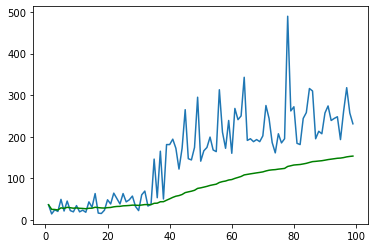

In [8]:
for i in range(1, episodes):
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)[:4]
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score 
            if (i + 1) % 10 == 0:
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break
            
    episode_number.append(i)
    rewards.append(score)
    average_reward_number.append(average_reward/i)


plt.plot(episode_number, rewards)
plt.plot(episode_number, average_reward_number, color = 'g')
plt.show()

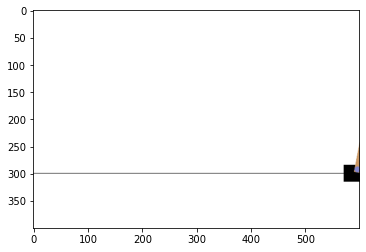

Score: 230.0


<bound method Wrapper.close of <TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>>>

In [9]:
random.seed(29)  
score = 0
state = env.reset()
done = False
  
while not done:
    clear_output(wait=True)
    plt.imshow(env.render('rgb_array'))
    show()
    action = agent.choose_action(state)
    state_, reward, done, info = env.step(action)[:4]
    state_ = np.reshape(state_, [1, observation_space])
    state = state_
    score += reward
    
print('Score:', score)
env.close